In [1]:
import os
import cv2
import keras
import numpy as np
import contextlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import gradio as gr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from mtcnn import MTCNN
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras.applications import EfficientNetV2S
from keras.layers import Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

c:\Users\vedha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Define preprocessing function based on the model
# Making it global since it is used many times
global preprocess_input
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [2]:
gender_predict_with_mask_model = load_model('EfficientNetV2S_Models/gender_prediction_with_mask.keras')

In [3]:
trained_model_for_face_mask_detection = load_model('EfficientNetV2S_Models/face_mask_detection_model_final.keras')

In [4]:
trained_model_for_gender_prediction_without_mask = load_model('EfficientNetV2S_Models/gender_prediction.keras')

In [9]:
detector = MTCNN()

def detect_and_crop_face(image_path):

    image = cv2.imread(image_path)
    
    # Resizing the image so that it takes less time to detect and crop
    image = cv2.resize(image, (520, 520))
    
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    faces = detector.detect_faces(image_rgb)

    if faces:
        # COnsidering only the first face
        face = faces[0]
        x, y, width, height = face['box']

        cropped_face = image_rgb[y:y+height, x:x+width]
        cropped_face = cv2.resize(cropped_face, (260, 260))
        # Changing the file itself
        cropped_image_path = image_path

        cv2.imwrite(cropped_image_path, cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR))
        return 1, image_path
    else:
        print("There are no faces in the image")
        return -1, None

In [5]:
def predict(model, image_path, to_predict, image_size=(260, 260)):
    
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict gender
    prediction = model.predict(img_array)
    probability = prediction[0][0] * 100
    
    result = ""
    if to_predict == 'Gender':
        if probability > 50:
            result = "Male"
            print(f"{result} ({probability:.2f}%)")
        else: 
            result = "Female"
            print(f"{result} ({100 - probability:.2f}%)")
    elif to_predict == 'Mask':
        if probability > 50:
            result = "WithoutMask"
            print(f"{result} ({probability:.2f}%)")
        else: 
            result = "WithMask"
            print(f"{result} ({100 - probability:.2f}%)")
    
    return result

In [7]:
def predict_single_image(test_image_path):
    x, cropped_image_path = detect_and_crop_face(test_image_path)
    image = mpimg.imread(test_image_path)
    plt.imshow(image)
    plt.axis('off') 
    plt.show()
    # If there is a face in the image
    if x == 1: 
        mask = predict(trained_model_for_face_mask_detection, cropped_image_path, "Mask")
        if mask == "WithMask":
            gender = predict(gender_predict_with_mask_model, cropped_image_path, "Gender")
        else:
            gender = predict(trained_model_for_gender_prediction_without_mask, cropped_image_path, "Gender")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


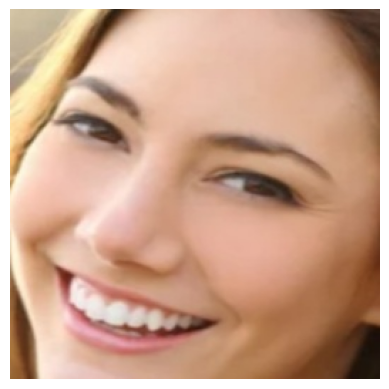

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
WithoutMask (100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Female (100.00%)


In [10]:
test_path = 'female_image_without_mask.jpg' # Insert file path of image you want the results of.
predict_single_image(test_path)